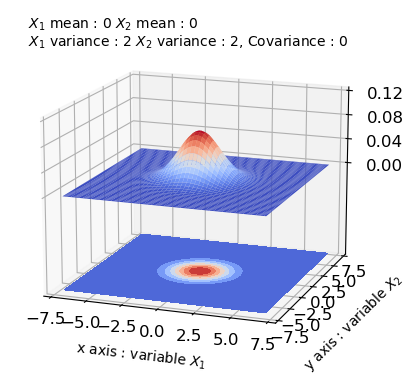

In [11]:
import pandas as pd
import numpy as np
from scipy.stats import multivariate_normal

import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import cm
import matplotlib
from mpl_toolkits.mplot3d import Axes3D

def multi_norm_3d(mu_list, Sigma_list):
    """
    인풋: 평균, 분산-공분산 행렬
    아웃풋 : 주어진 값에 따른 다변량 정규분포 그래프
    """
    
    # 2차원 그래프 범위
    N = 100
    X = np.linspace(-7, 7, N) # 1*N 행렬, X축 70개 간격
    Y = np.linspace(-7, 7, N)
    X, Y = np.meshgrid(X, Y) # 2차원 평면 X, Y에 격자점 N*N개
    
    # 3차원 배열
    pos = np.empty(X.shape + (2,)) # (N, N, 2)
    pos[:, :, 0] = X
    pos[:, :, 1] = Y
    
    # 평균 1차원 배열, 분산-공분산 2*2 행렬 설정
    mu = np.array(mu_list)
    Sigma = np.array(Sigma_list)
    Z = multivariate_normal(mu, Sigma).pdf(pos) # 다변량 정규분포 확률값
    
    # 3차원 그래프
    fig = plt.figure()
    # ax = fig.gca(projection = '3D') <- 이거 지금 사용 불가능
    ax = fig.add_subplot(projection = '3d')
    ax.plot_surface(X, Y, Z,
                    rstride = 2, # 행 방향 간격 3
                    cstride=  2, # 열 방향 간격 3
                    linewidth = 1,
                    cmap = cm.coolwarm)
    
    # 등고선 그래프
    cset = ax.contourf(X, Y, Z, 
                       offset = -0.15,
                       cmap = cm.coolwarm)
    ax.set_zlim(-0.15, 0.1) # z축 범위
    ax.set_zticks(np.linspace(0, 0.12, 4))
    ax.view_init(15, 290)
    ax.set_xlabel('x axis : variable $X_1$')
    ax.set_ylabel('y axis : variable $X_2$')
    
    # 눈금값 크기 조절 및 라벨 간격 설정
    ax.tick_params(axis = 'x', labelsize = 12, pad = 0)
    ax.tick_params(axis = 'y', labelsize = 12, pad = -1.5)
    ax.tick_params(axis = 'z', labelsize = 12, pad = 10)    
    ax.text2D(0.05, 0.95, f"$X_1$ mean : {mu[0]} $X_2$ mean : {mu[1]}", transform = ax.transAxes)
    ax.text2D(0.05, 0.90, f"$X_1$ variance : {Sigma[0][0]} $X_2$ variance : {Sigma[1][1]}, Covariance : {Sigma[0][1]}", transform = ax.transAxes)
    plt.savefig(f"이변량 그래프 : {mu[0]}_{Sigma[0][0]}_{Sigma[0][1]}.png", bbox_inches = 'tight')
    
    return plt.show()

multi_norm_3d([0, 0], [[2, 0], [0, 2]])

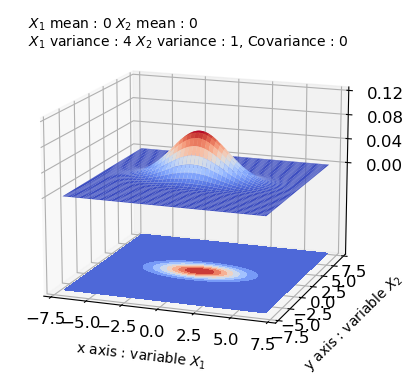

In [12]:
multi_norm_3d([0, 0], [[4, 0], [0, 1]])

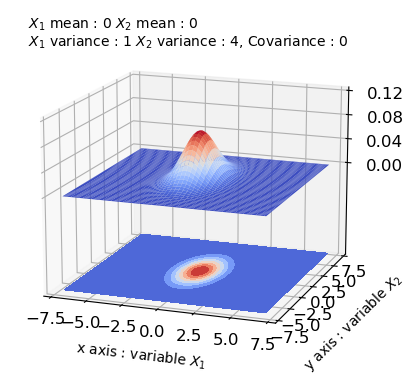

In [13]:
multi_norm_3d([0, 0], [[1, 0], [0, 4]])

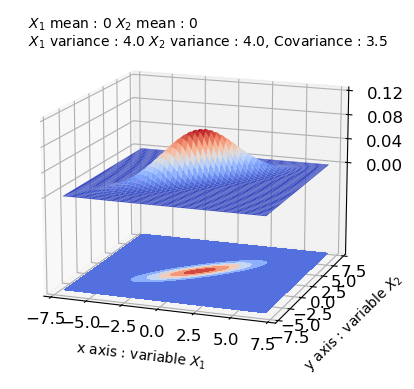

In [14]:
multi_norm_3d([0, 0], [[4, 3.5], [3.5, 4]])

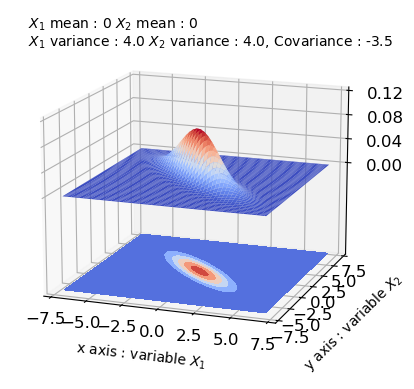

In [15]:
multi_norm_3d([0, 0], [[4, -3.5], [-3.5, 4]])

## 산포도와 상관계수

Text(0.5, 1.0, 'Low corrcoef(Negative)')

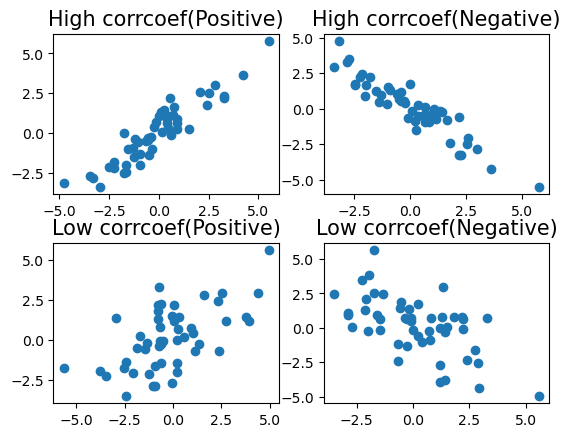

In [18]:
# 1. 이변량 정규분포 무작위 생성 함수

def generate_2rv(mu, sd, corr, size):
    """
    인풋 : 평균리스트, 표준편차리스트, 상관계수, 크기
    출력 : 이변량 정규분포 df
    """
    
    np.random.seed(21)
    covs = np.array([[sd[0] ** 2, sd[0]*sd[1]*corr],
                    [sd[0]*sd[1]*corr, sd[1] ** 2]])
    
    # 무작위로 이변량 정규분포 만들기
    df_bivar = np.random.multivariate_normal(np.array(mu), covs, size)
    df_bivar = pd.DataFrame(df_bivar)
    df_bivar.rename(columns = {0 : 'col1', 1 : 'col2'}, inplace = True)
    return df_bivar

# high : 상관계수 += 0.95, low : 상관계수 +- 0.7
df_high_p = generate_2rv([0, 0], [2, 2], 0.95, 50)
df_high_n = generate_2rv([0, 0], [2, 2], -0.95, 50)
df_low_p = generate_2rv([0, 0], [2, 2], 0.7, 50)
df_low_n = generate_2rv([0, 0], [2, 2], -0.7, 50)

TITLE = 15

plt.figure()
plt.subplots_adjust(wspace = 0.2, hspace = 0.3)

plt.subplot(2, 2, 1)
plt.scatter(df_high_p['col1'], df_high_p['col2'])
plt.title("High corrcoef(Positive)", fontsize = TITLE)

plt.subplot(2, 2, 2)
plt.scatter(df_high_n['col1'], df_high_n['col2'])
plt.title("High corrcoef(Negative)", fontsize = TITLE)

plt.subplot(2, 2, 3)
plt.scatter(df_low_p['col1'], df_low_p['col2'])
plt.title("Low corrcoef(Positive)", fontsize = TITLE)

plt.subplot(2, 2, 4)
plt.scatter(df_low_n['col1'], df_low_n['col2'])
plt.title("Low corrcoef(Negative)", fontsize = TITLE)

### 공선성 확인하기

In [20]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

pd.options.display.float_format = '{:.3f}'.format

mu = np.array([10, 10, 10, 10])
sd = [1, 2, 3, 4]
corr = 0.85
n_size = 1000

# 분산-공분산 행렬
covs = np.array([
    [sd[0]**2 , sd[0]*sd[1]*corr, sd[0]*sd[2]*corr, sd[0]*sd[3]*corr],
    [sd[1]*sd[0]*corr, sd[1]**2, sd[1]*sd[2]*corr, sd[1]*sd[3]*corr],
    [sd[2]*sd[0]*corr, sd[2]*sd[1]*corr, sd[2]**2, sd[2]*sd[3]*corr],
    [sd[3]*sd[0]*corr, sd[3]*sd[1]*corr, sd[3]*sd[2]*corr, sd[3]**2]
])

np.random.seed(21)
df_cl = np.random.multivariate_normal(mu, covs, size = n_size) # 다변량 정규분포
df_cl = pd.DataFrame(df_cl)
df_cl.rename(columns = {0 : 'col1', 1:'col2', 2 : 'col3', 3: 'col4'}, inplace = True)

df_cl['col5'] = df_cl['col1']*3 + 10
df_cl.corr()

,col1,col2,col3,col4,col5
col1,1.000,0.877,0.870,0.875,1.000
col2,0.877,1.000,0.859,0.867,0.877
col3,0.870,0.859,1.000,0.866,0.870
col4,0.875,0.867,0.866,1.000,0.875
col5,1.000,0.877,0.870,0.875,1.000


#### VIF 계산

In [25]:
def get_vif(df):
    vif = pd.DataFrame()
    vif['열'] = df.columns
    
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    
    return vif

df_cl_vif =get_vif(df_cl)
df_cl_vif

,열,VIF
0,col1,5247.923
1,col2,5.734
2,col3,5.478
3,col4,5.822
4,col5,4373.508


In [26]:
df_cl_except_1 = df_cl.drop('col1', axis = 1)
df_cl_except_1_vif = get_vif(df_cl_except_1)
df_cl_except_1_vif

,열,VIF
0,col2,132.151
1,col3,55.979
2,col4,30.420
3,col5,63.675
